In [9]:
import sys
import pickle
sys.path.insert(0,'./')
# from importlib import reload

In [10]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [11]:
from cov_3X2 import *
from fisher import *

In [12]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [13]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [14]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [15]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [24]:
def readclxipm(filename):
    nz_bins=4
    na=20
    nz=np.int(nz_bins*(nz_bins+1.)/2.)
    print(nz)
    n_theta=ndesa=20
    tp_fits = fits.open(filename)[1].data #fitsio.FITS(filename)
    #xip = tp_fits['xip']
    #theta = xip['ang'][:ndesa]
    #thc = np.delete(theta,range(ndesa-na))

    ccl = tp_fits#[1]
    ccl_xip=ccl[:2*ndesa*nz,:2*ndesa*nz] #factor of 2 for xi_-
    #print ccl_xip[399,390:399]
    cov=np.zeros((2*nz*na,2*nz*na))
    for z1 in range(2*nz):
        for a1 in range(na):
            i1 = a1+z1*na
        ## The index in the original matrix is skewed because that matrix contains
        ## angles that have been cut. So 
            i1ccl = (a1+ndesa-na) + z1*ndesa
            for z2 in range(2*nz):
                for a2 in range(na):
                    i2 = a2 + z2*na
                ## The index in the original matrix is skewed because that matrix contains
                ## angles that have been cut. So 
                    i2ccl = (a2+ndesa-na) + z2*ndesa
                    cov[i1,i2]=ccl_xip[i1ccl,i2ccl]
    return cov

In [19]:
fname='/home/deep/data/DES/2pt_NG_mcal_final_7_11.fits'
DES_dat=fits.open(fname)

In [67]:
cov_des=readclxipm(filename=fname)
# corr_des=cc.corr_matrix(cov_des)

10


In [31]:
pz=Table.read(fname,format='fits',hdu=6)

In [32]:
f_sky=1321./(4*np.pi/d2r**2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


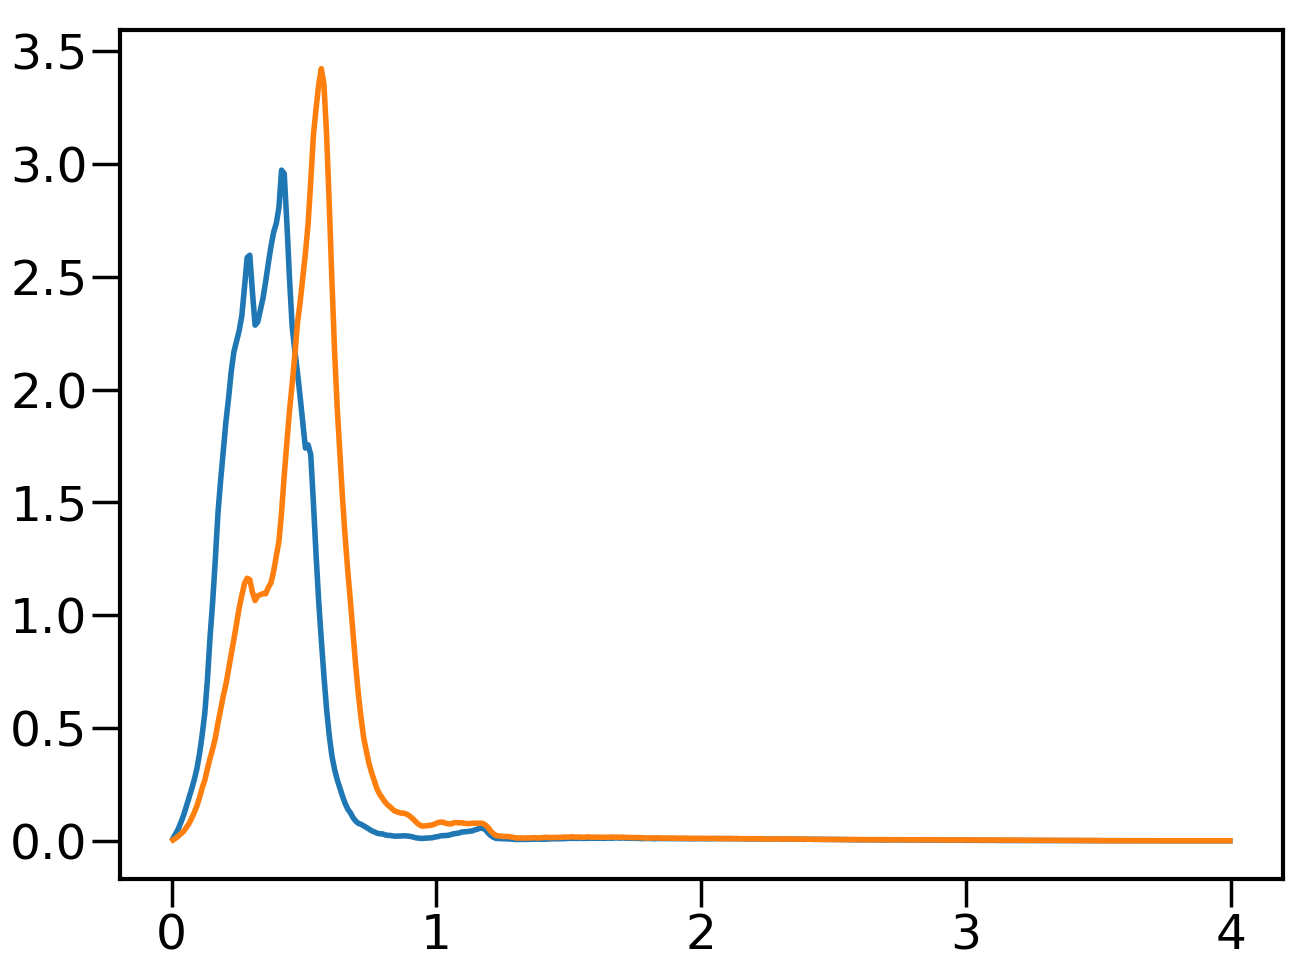

In [34]:
t=DES_dat[6].data
plot(t['Z_MID'],t['BIN1'])
plot(t['Z_MID'],t['BIN2'])

In [35]:
#Setup redshift bins
zmin=0
zmax=3

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=fname)

ns0=np.sum(zs_bins['nz'])

SSV_cov=False
tidal_SSV=False

In [41]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins*10)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [42]:
#Hankel Transform setup
l_max=1e4
l_min=2
l0=np.arange(l_min,l_max)
prune_theta=1
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [43]:
bin_xi=True

In [44]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=zs_bins,l_bins=l_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=0.39)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

06:30:28 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2)]
06:30:28 INFO:pruning theta, log_space:True n_f:1
06:30:28 INFO:pruned theta:115
06:30:28 INFO:nr:114
06:30:31 INFO:changed l_max to 11594.133199922566 to cover theta_min. j_nu=4
06:30:31 INFO:pruning theta, log_space:True n_f:1
06:30:31 INFO:pruned theta:131
06:30:31 INFO:nr:130


In [45]:
l_bins=np.logspace(1,3,40)

In [47]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta': XI_H.HT.theta[(2,2)],'m1_m2':[(2,2),(2,-2)]}
%time WT=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zs_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT,sigma_gamma=0.39,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 183 ms, sys: 200 ms, total: 383 ms
Wall time: 6.98 s


In [52]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': np.arange(2,l_max*2,dtype='int'),'theta': XI_H.HT.theta[(2,2)],'m1_m2':[(2,2),(2,-2)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zs_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=0.39,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 331 ms, sys: 264 ms, total: 594 ms
Wall time: 27.3 s


In [53]:
%time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time xiWG=XI_W.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

[('shear', 'shear')]


/usr/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 14.3 s, sys: 125 ms, total: 14.4 s
Wall time: 5.83 s
[('shear', 'shear')]


/usr/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 14.8 s, sys: 55.5 ms, total: 14.8 s
Wall time: 5.94 s
[('shear', 'shear')]


/usr/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 14.4 s, sys: 58.5 ms, total: 14.5 s
Wall time: 5.87 s


In [54]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

20 20 2
CPU times: user 2min 13s, sys: 2.46 s, total: 2min 16s
Wall time: 9.63 s


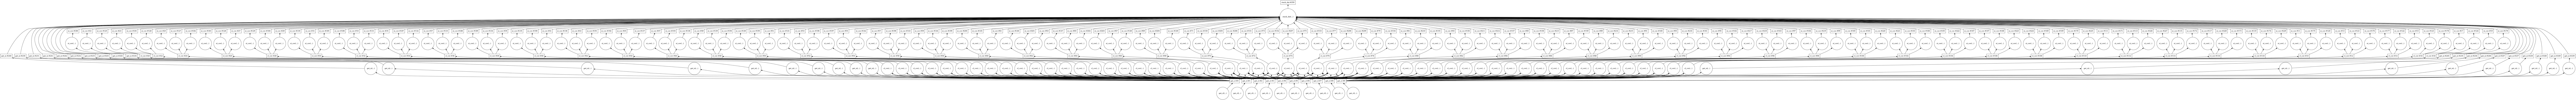

In [55]:
xiHG['stack'].visualize() #compute graph

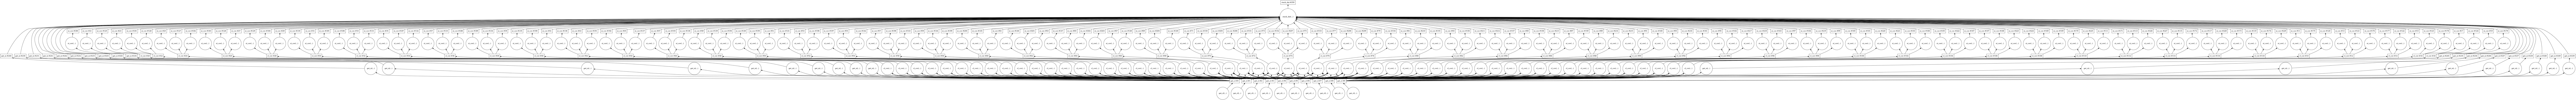

In [56]:
xiWG['stack'].visualize() #compute graph

In [57]:
%time xiW=xiWG['stack'].compute()
%time xiW_L=xiWG_L['stack'].compute()

20 20 2
CPU times: user 1min 23s, sys: 2.65 s, total: 1min 25s
Wall time: 6 s
20 20 2
CPU times: user 2min 50s, sys: 4.54 s, total: 2min 55s
Wall time: 12.2 s


In [58]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiW_inv=np.linalg.inv(xiW['cov']*f)
print (np.sqrt(np.dot(xiW['xi'],np.dot(cov_xiW_inv,xiW['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

46.45859898015721
102.45204420558143
75.92320818350454


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
06:33:57 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=42.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


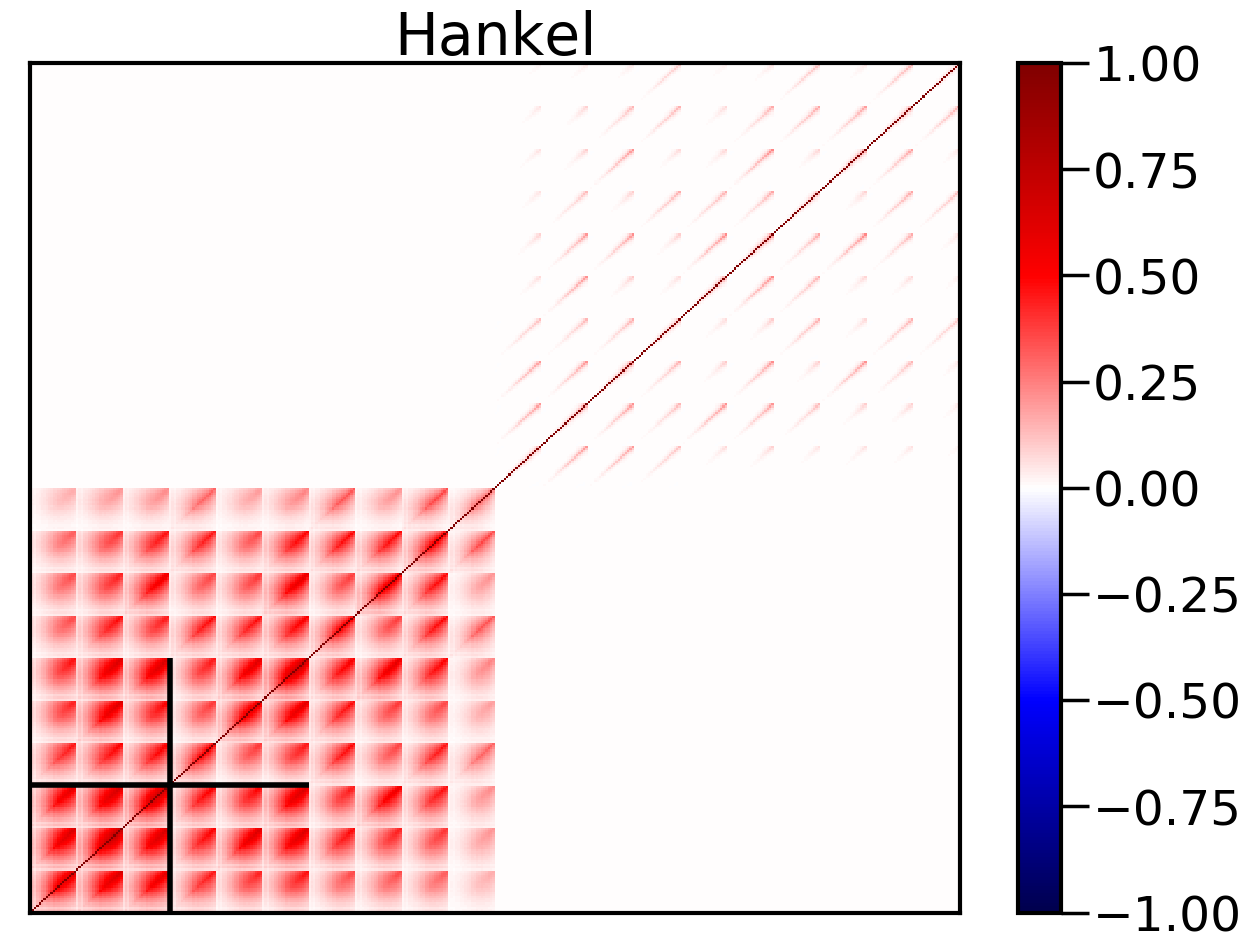

In [59]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


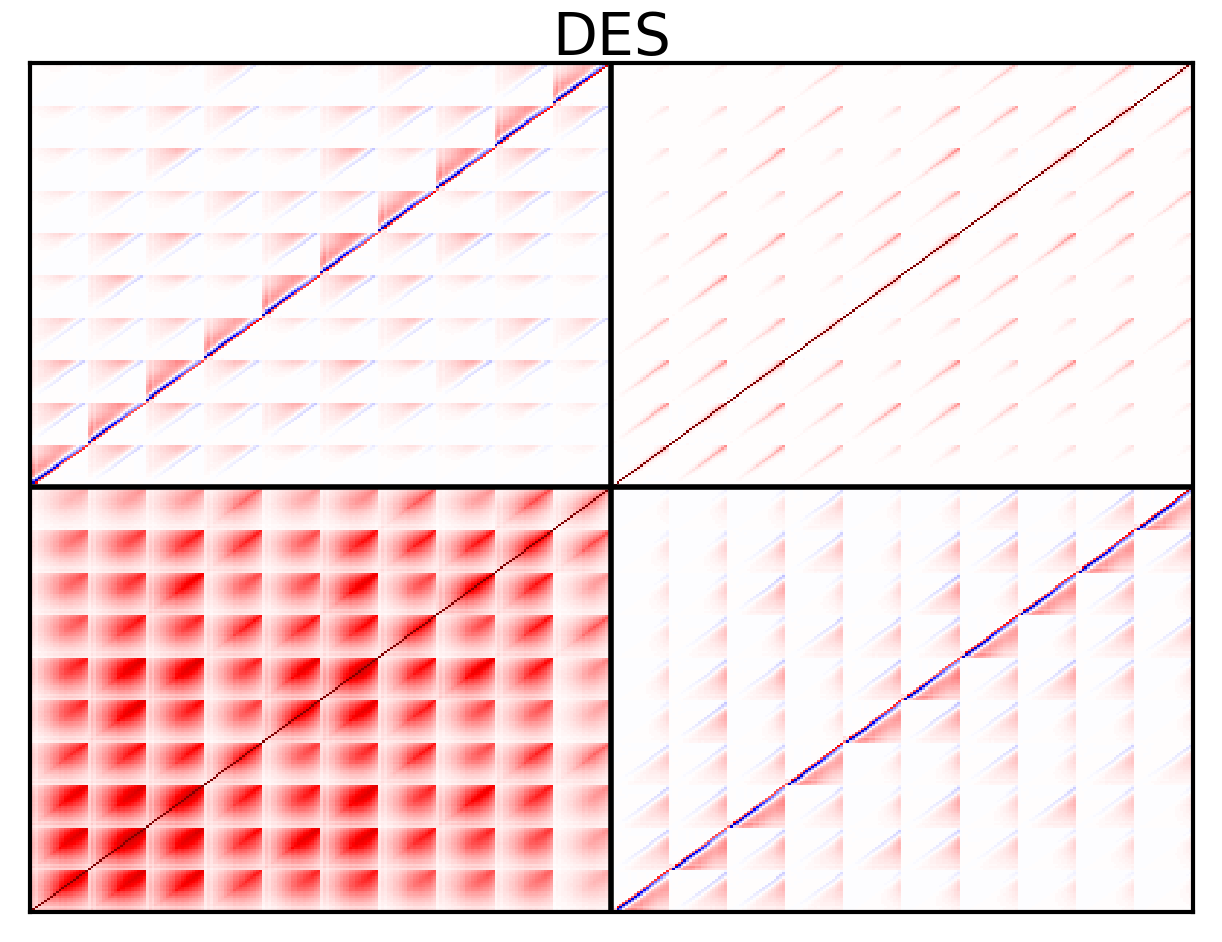

In [60]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('DES')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


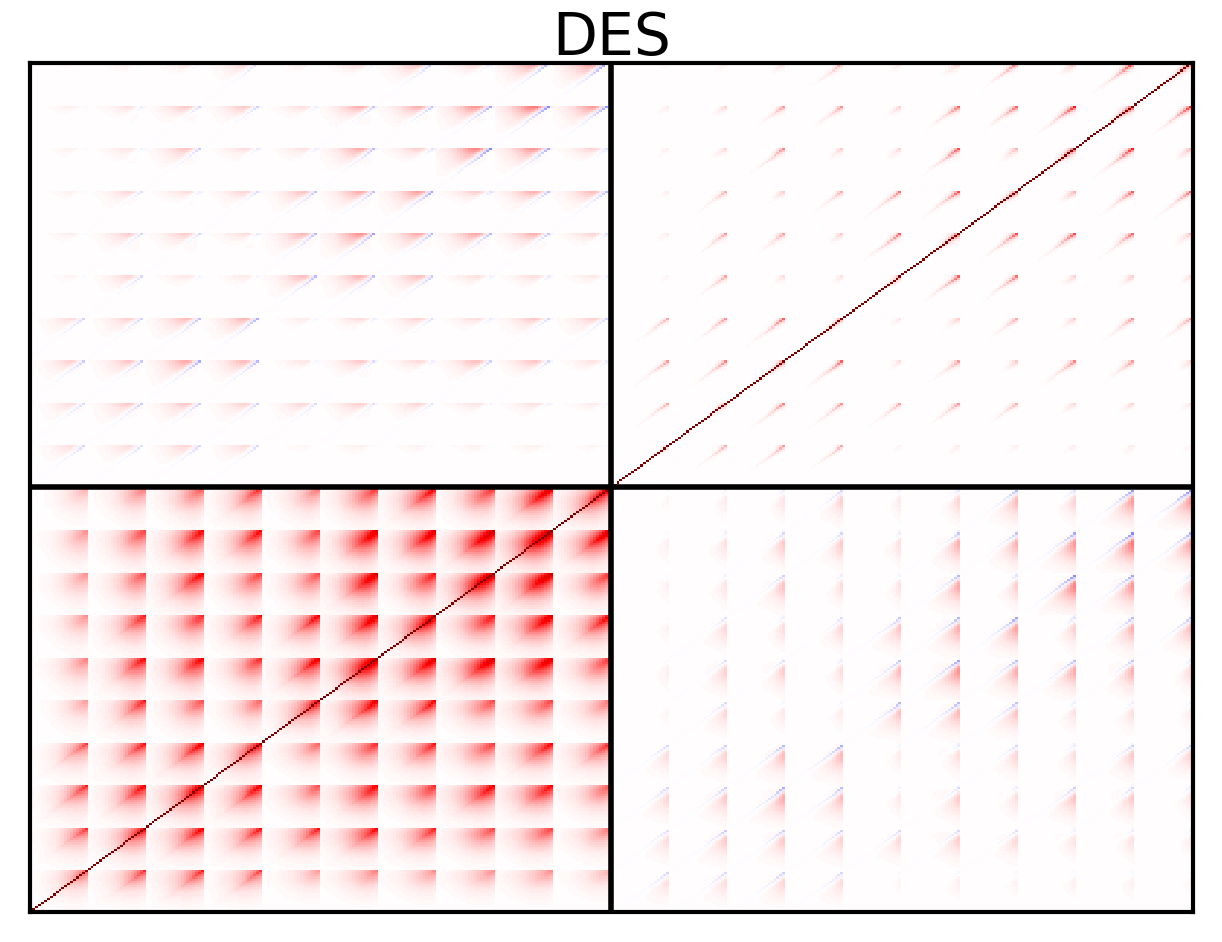

In [68]:
corr_des=cc.corr_matrix(cov_des)
pcolor(corr_des,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('DES')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


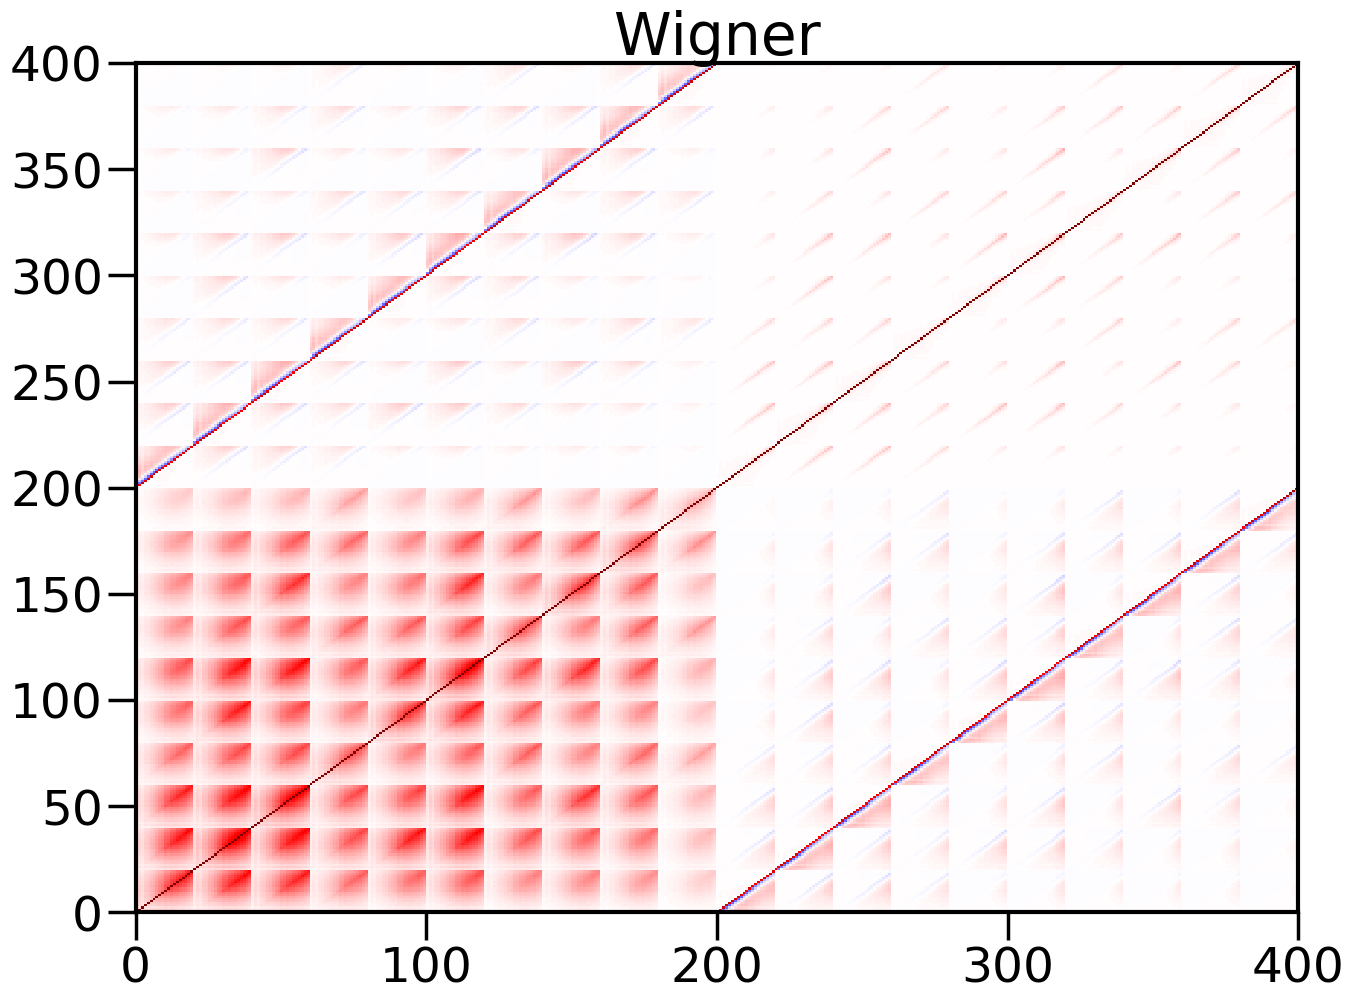

In [69]:
cc=XI_W.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [70]:
corr=('shear','shear')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


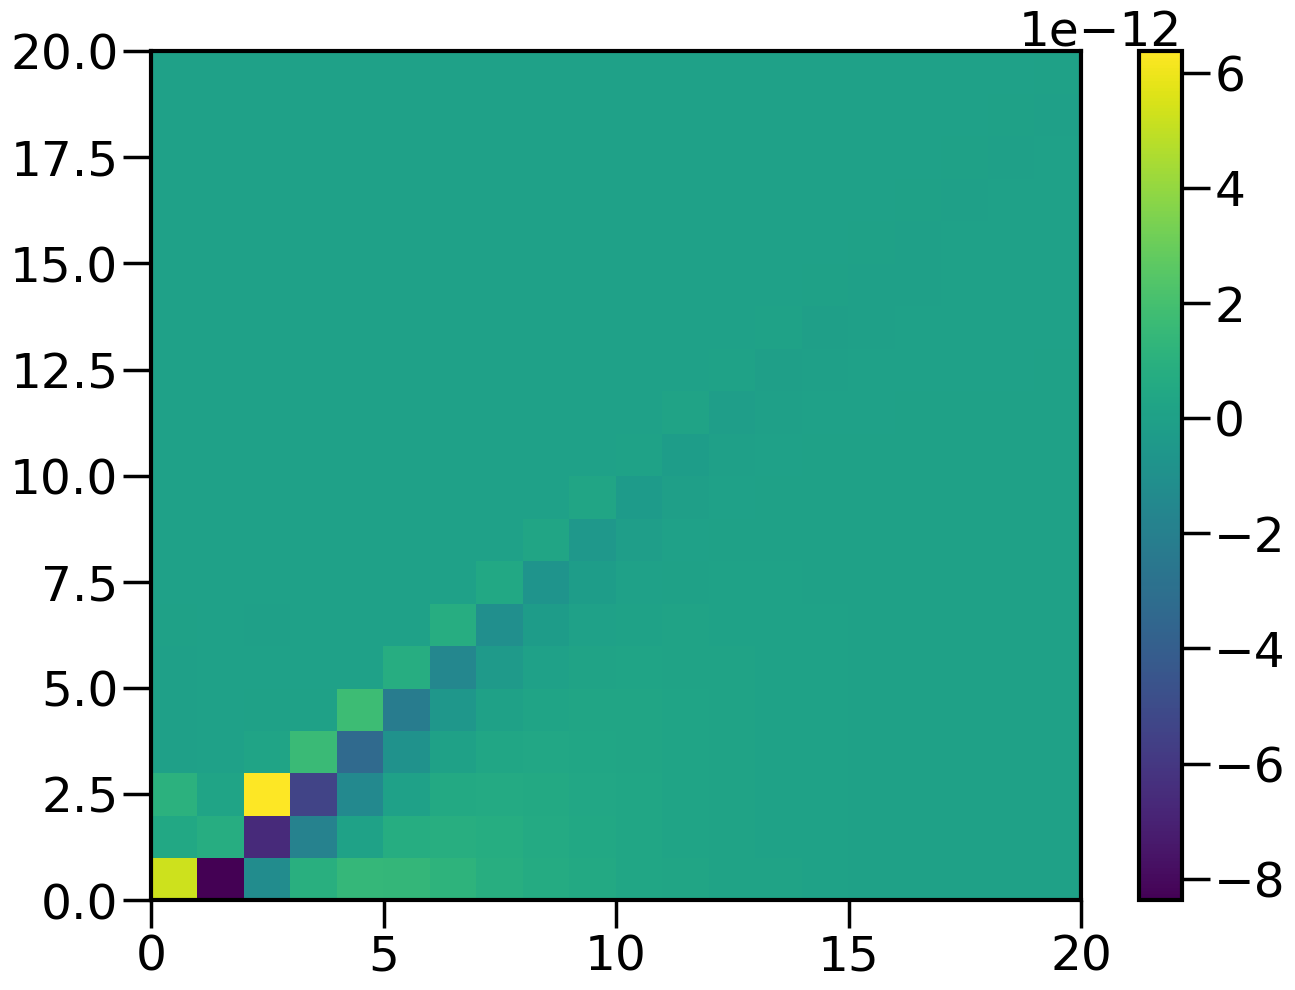

In [71]:
m1m2=(2, 2, 2, -2)
i=0
j=0
cov_t=xiWG['cov'][corr+corr][m1m2][(i,j,i,j)].compute()
pcolor(cov_t['final'])
colorbar()
# print (cov_t)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
06:37:14 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
06:37:14 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
06:37:14 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
06:37:14 DEBUG:findfont: Matching :family=STIXNonUnicode:style=no

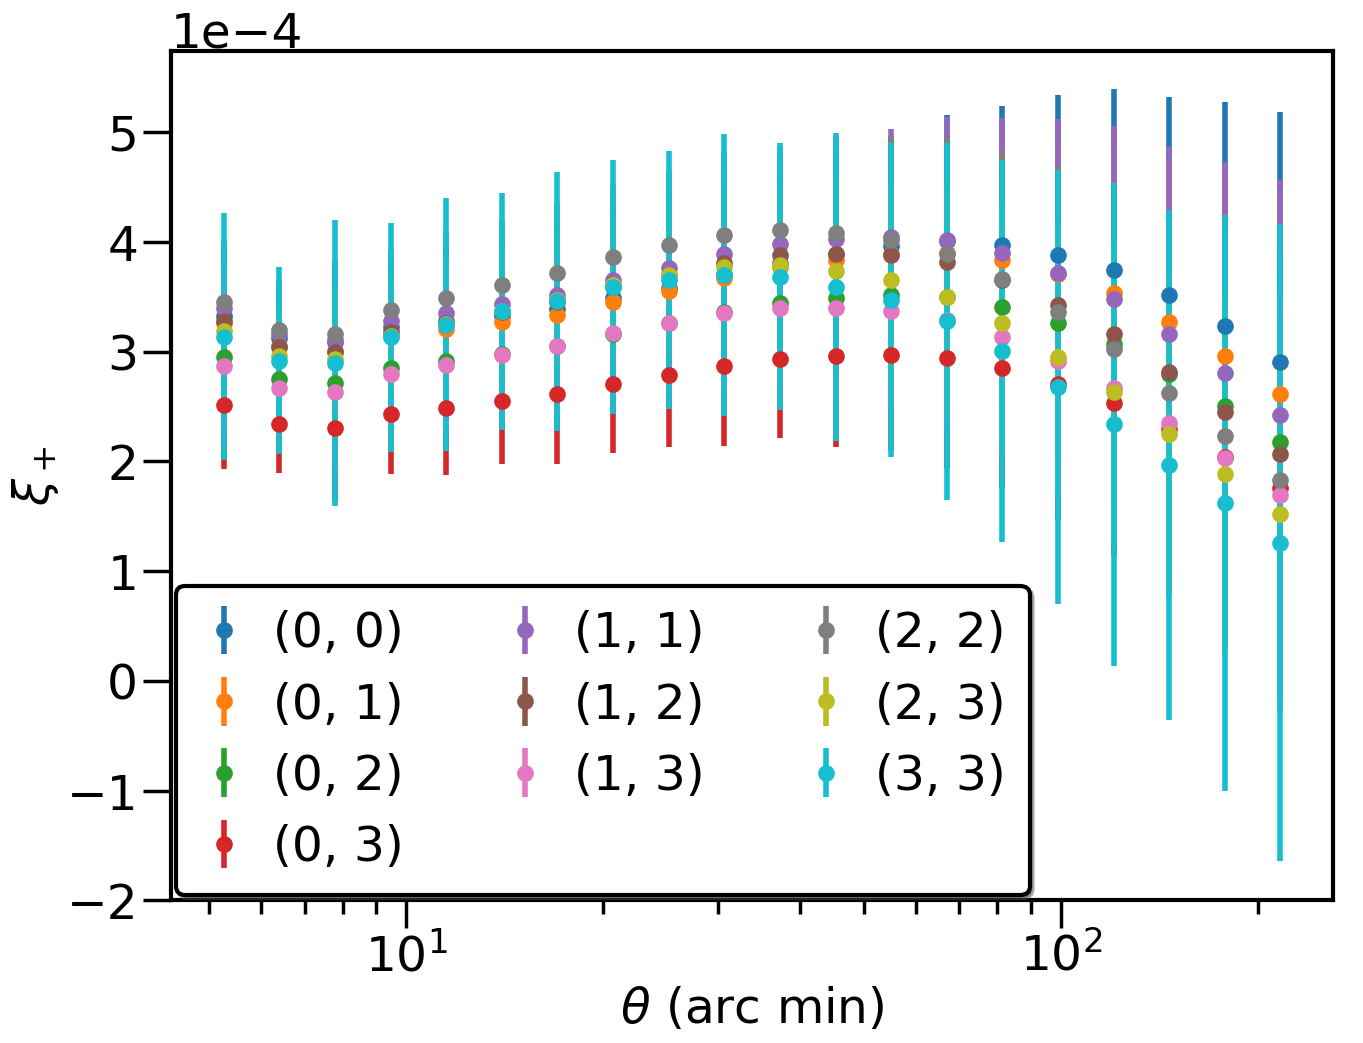

In [72]:
m1m2=(2,2)
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb/d2r,thb/d2r*xiHG['xi'][corr][m1m2][(i,j)].compute(),thb/d2r*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (arc min)')
ylabel(r'$\xi_+$')
legend(ncol=3)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


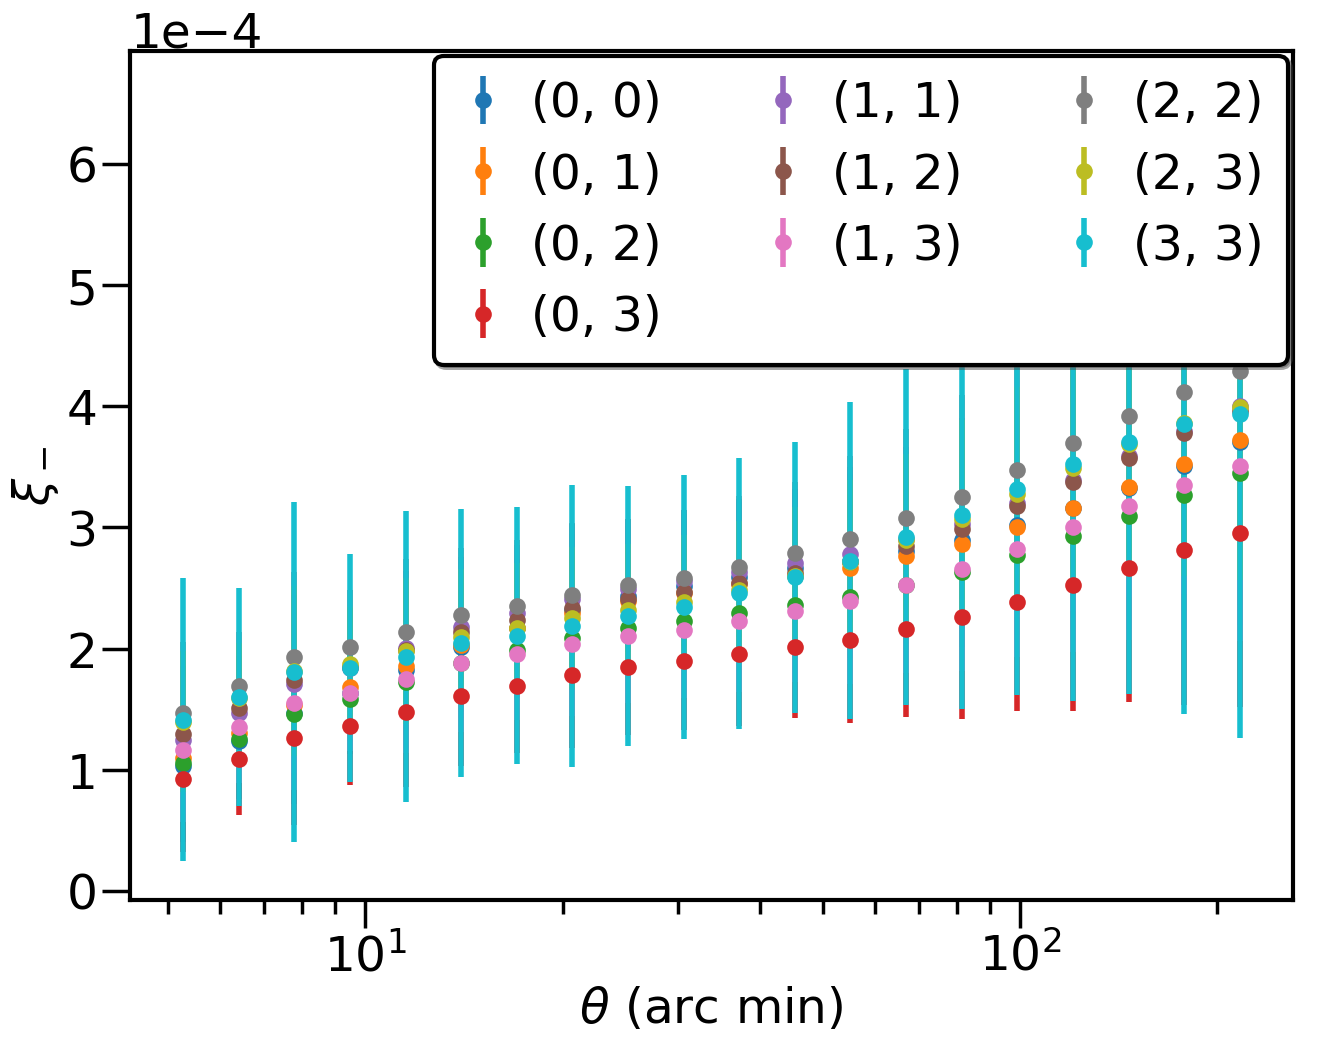

In [73]:
m1m2=(2,-2)
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb/d2r,thb/d2r*xiHG['xi'][corr][m1m2][(i,j)].compute(),thb/d2r*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (arc min)')
ylabel(r'$\xi_-$')
legend(ncol=3)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


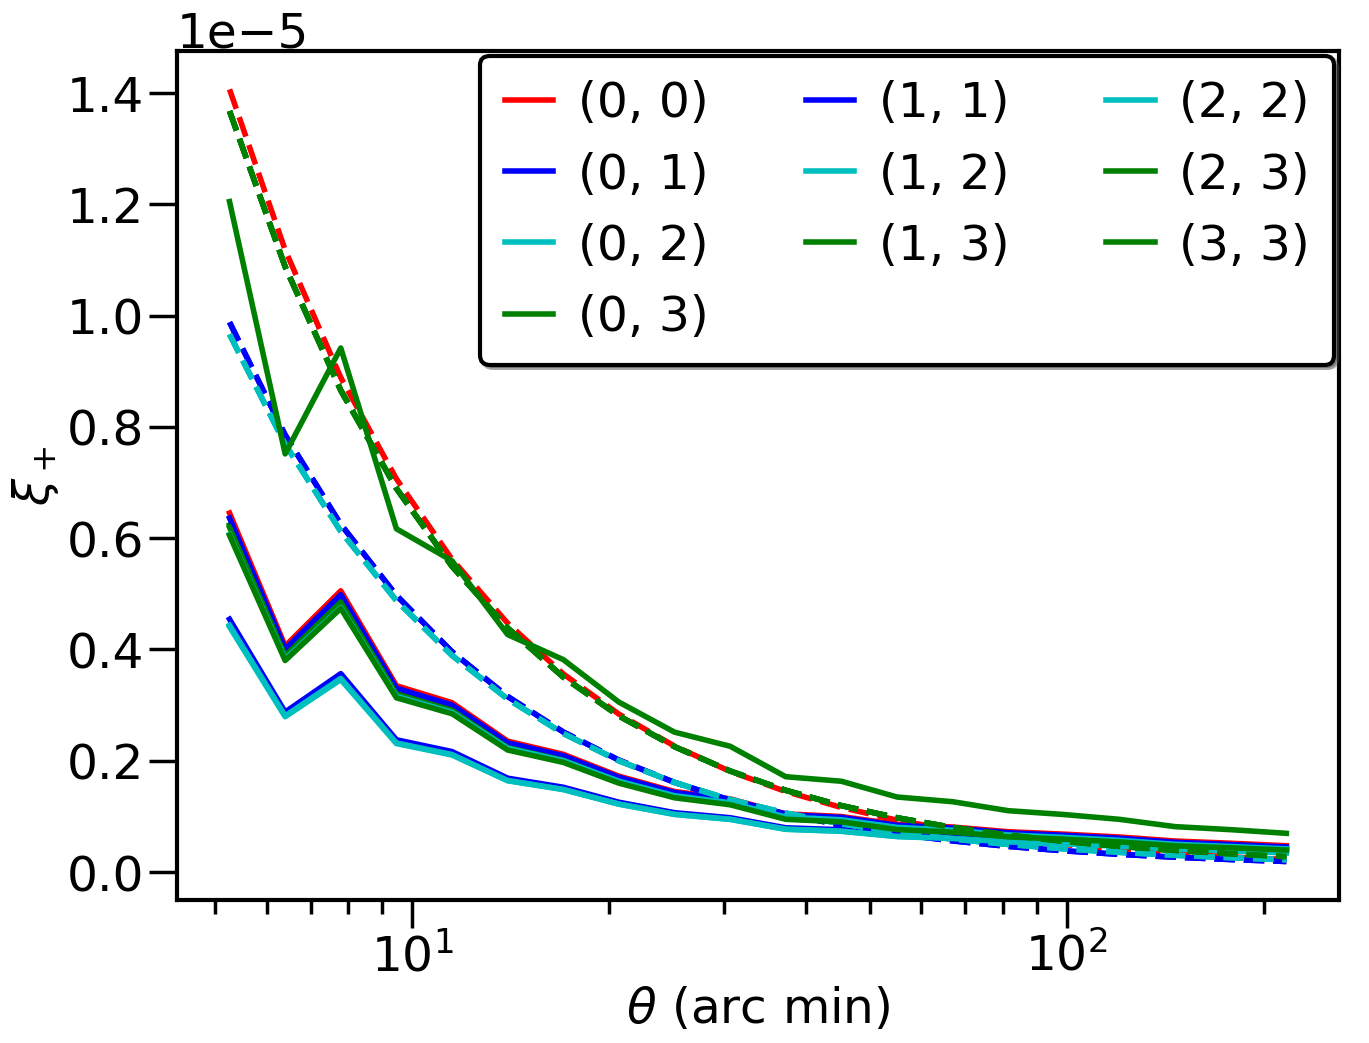

In [76]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        plot(thb/d2r,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j),
            c=cs[(i2+j2)%len(cs)])
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.sqrt(np.diag(cov_des[indx0:indx0+nth,indx0:indx0+nth])),c=cs[(i2+j2)%len(cs)],ls='--')
        j2+=1
    i2+=1
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (arc min)')
ylabel(r'$\xi_+$')
legend(ncol=3)

In [77]:
th,Win2=XI_W.HT.projected_correlation(l_cl=XI_W.l,m1_m2=(2,2),cl=XI_W.cov_utils.Win)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


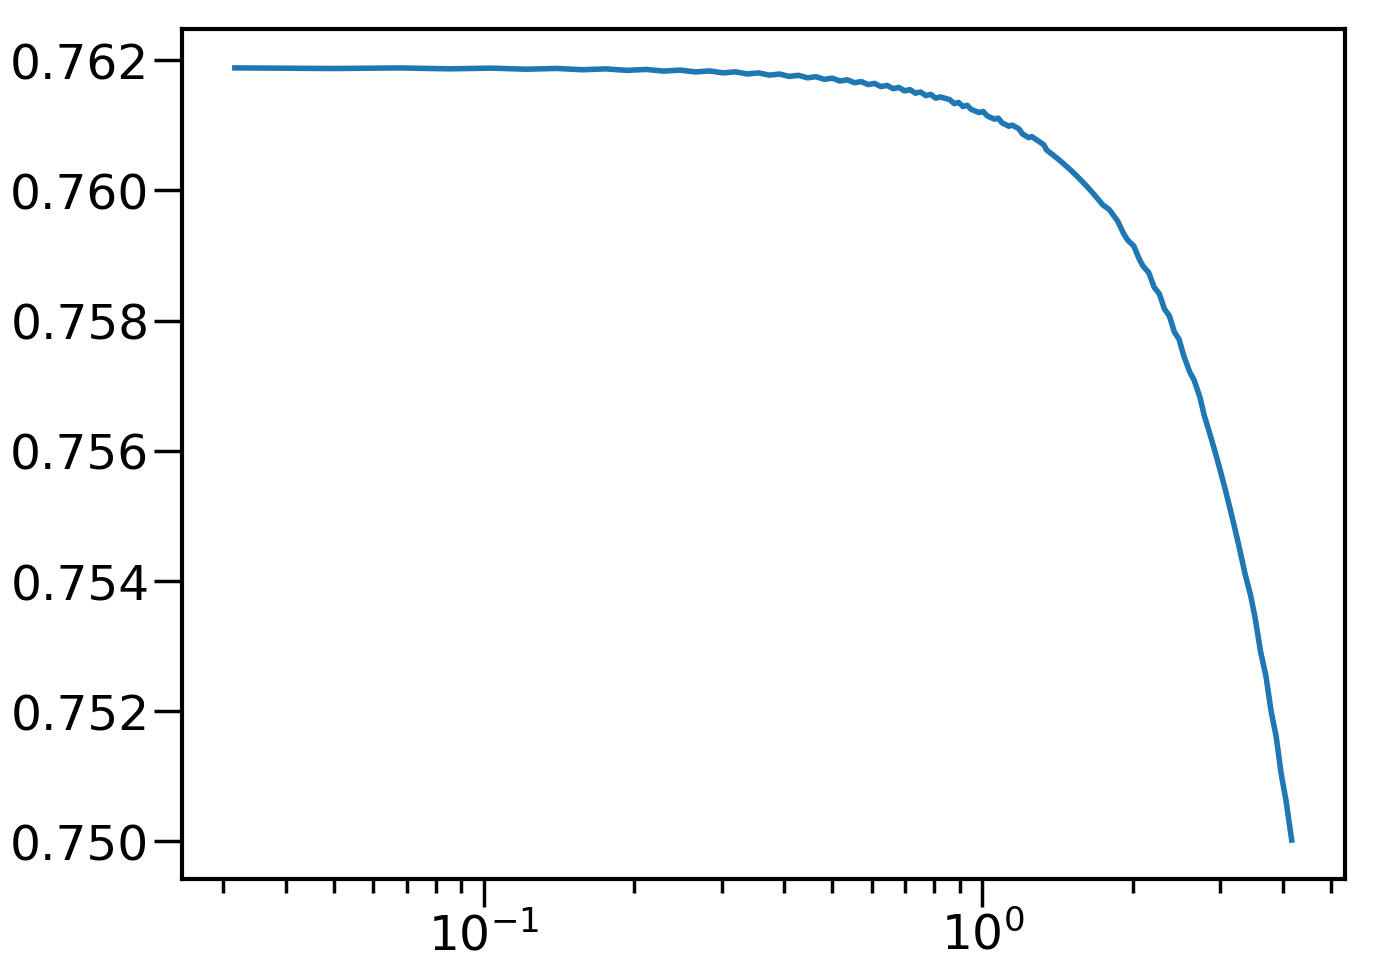

In [78]:
plot(th/d2r,Win2)
xscale('log')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


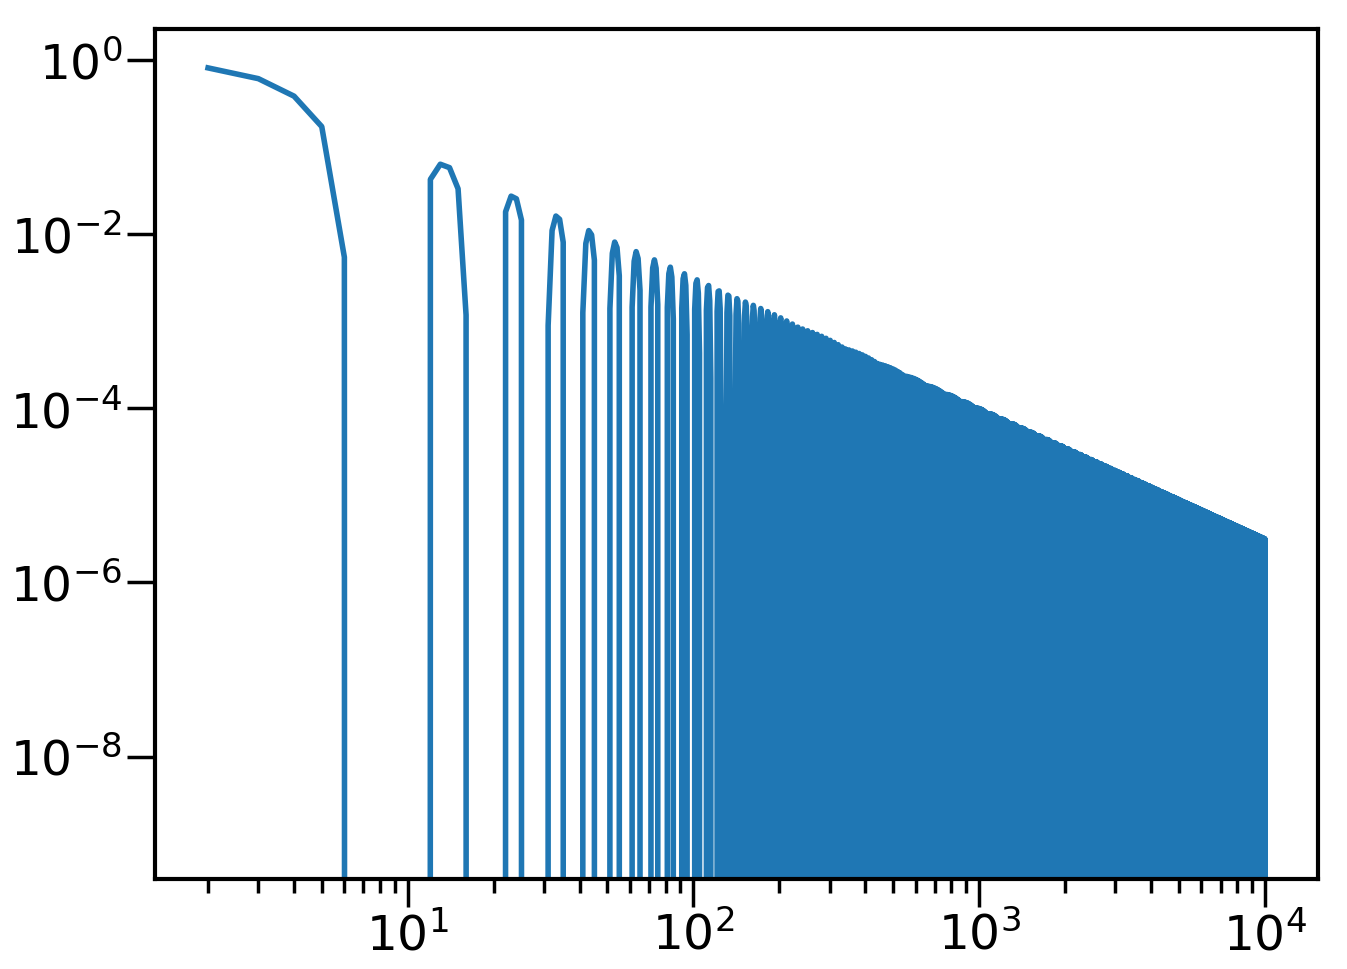

In [79]:
plot(XI_W.l,XI_W.cov_utils.Win)
xscale('log')
yscale('log')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


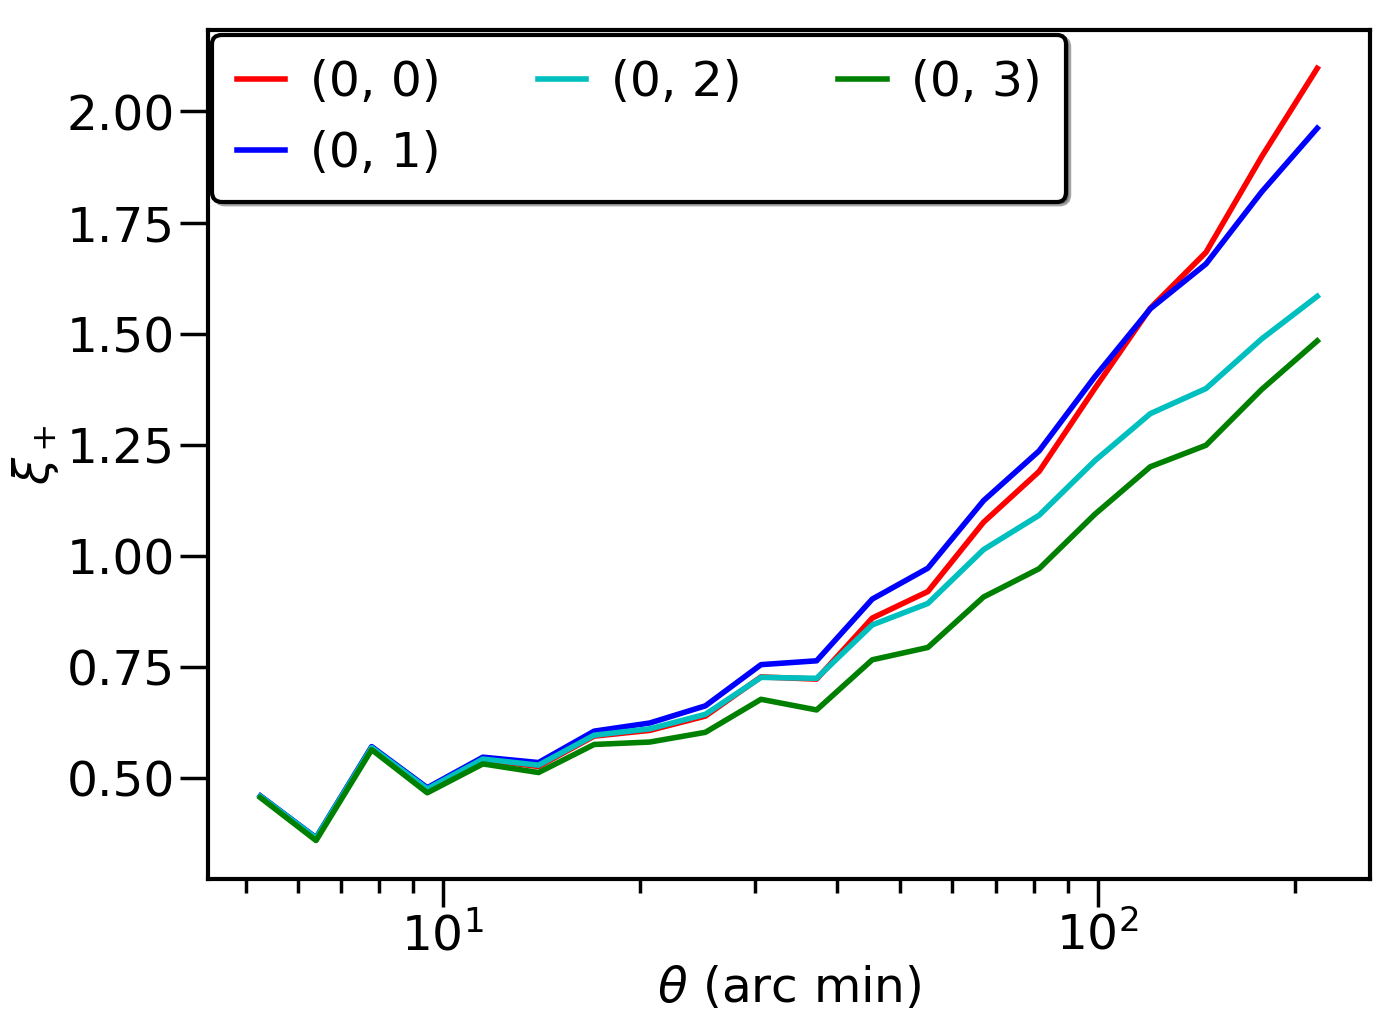

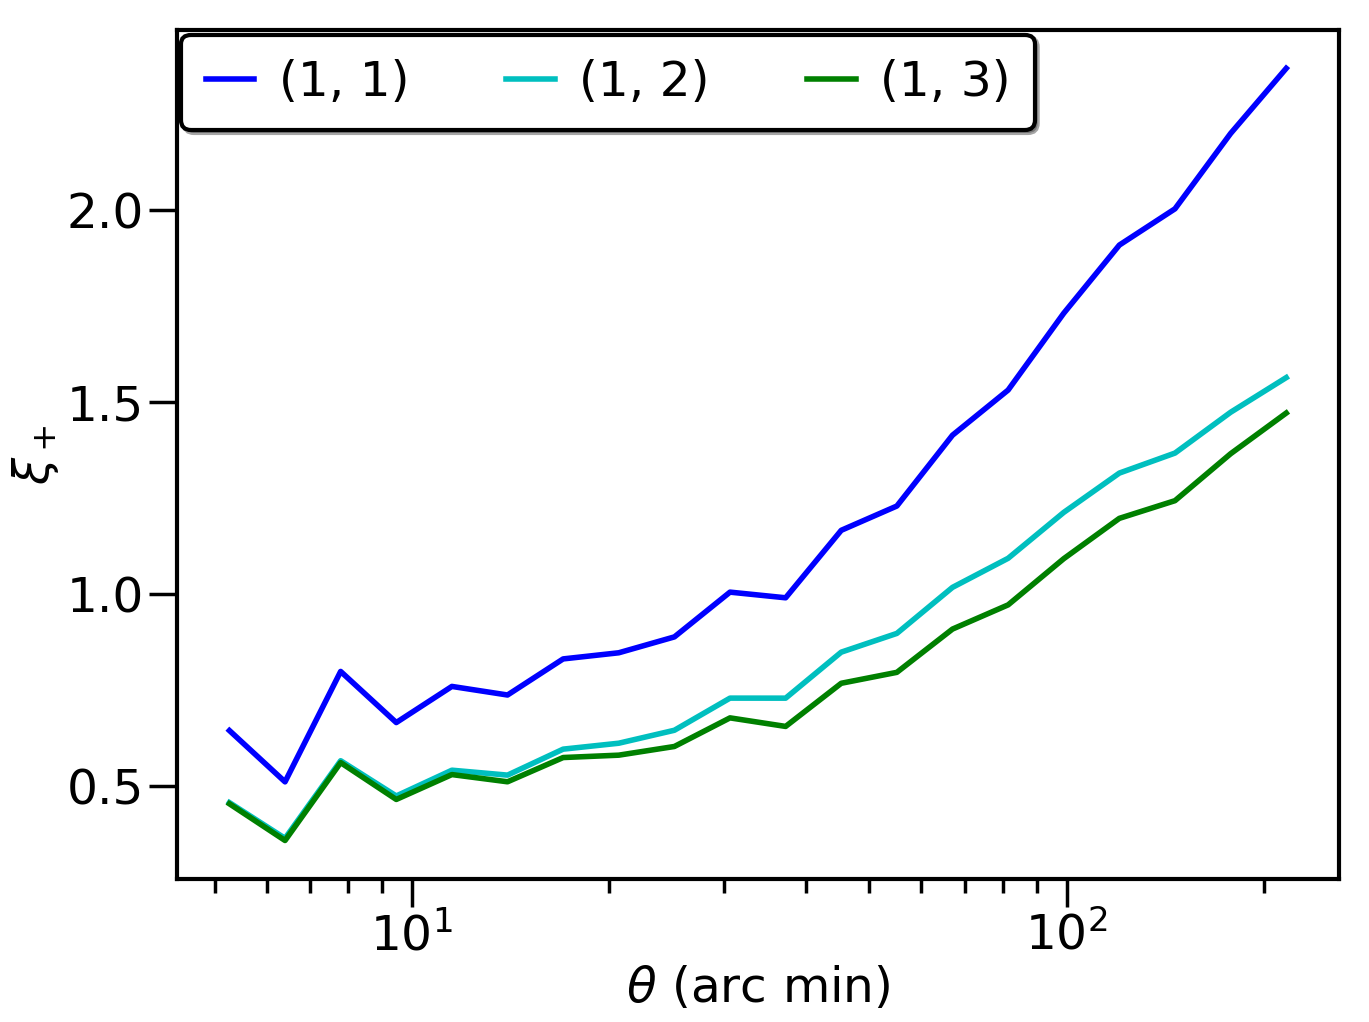

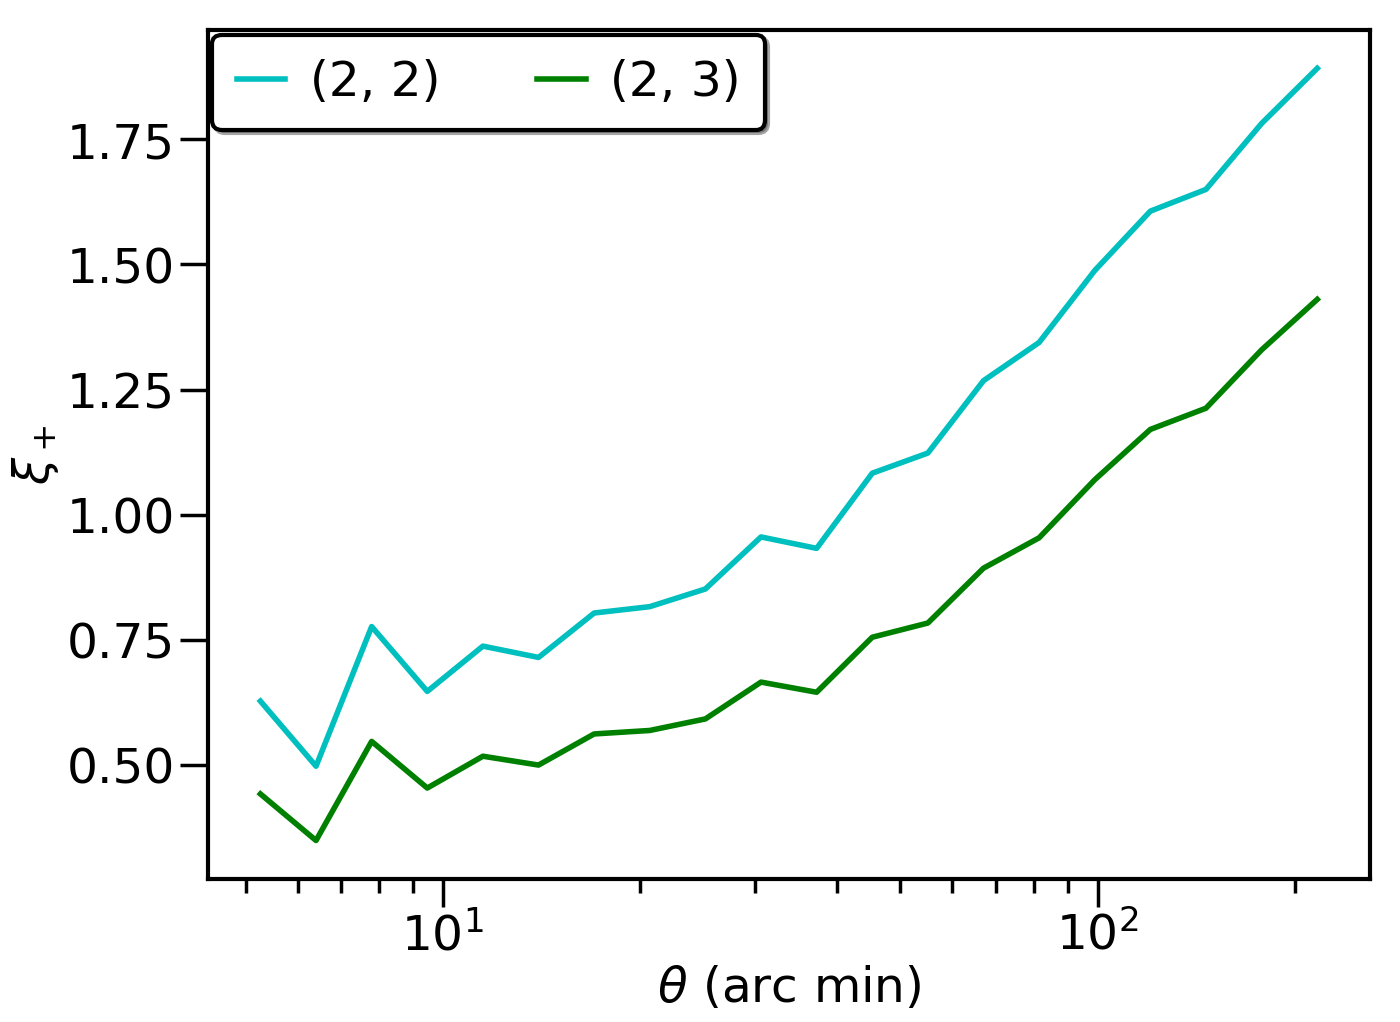

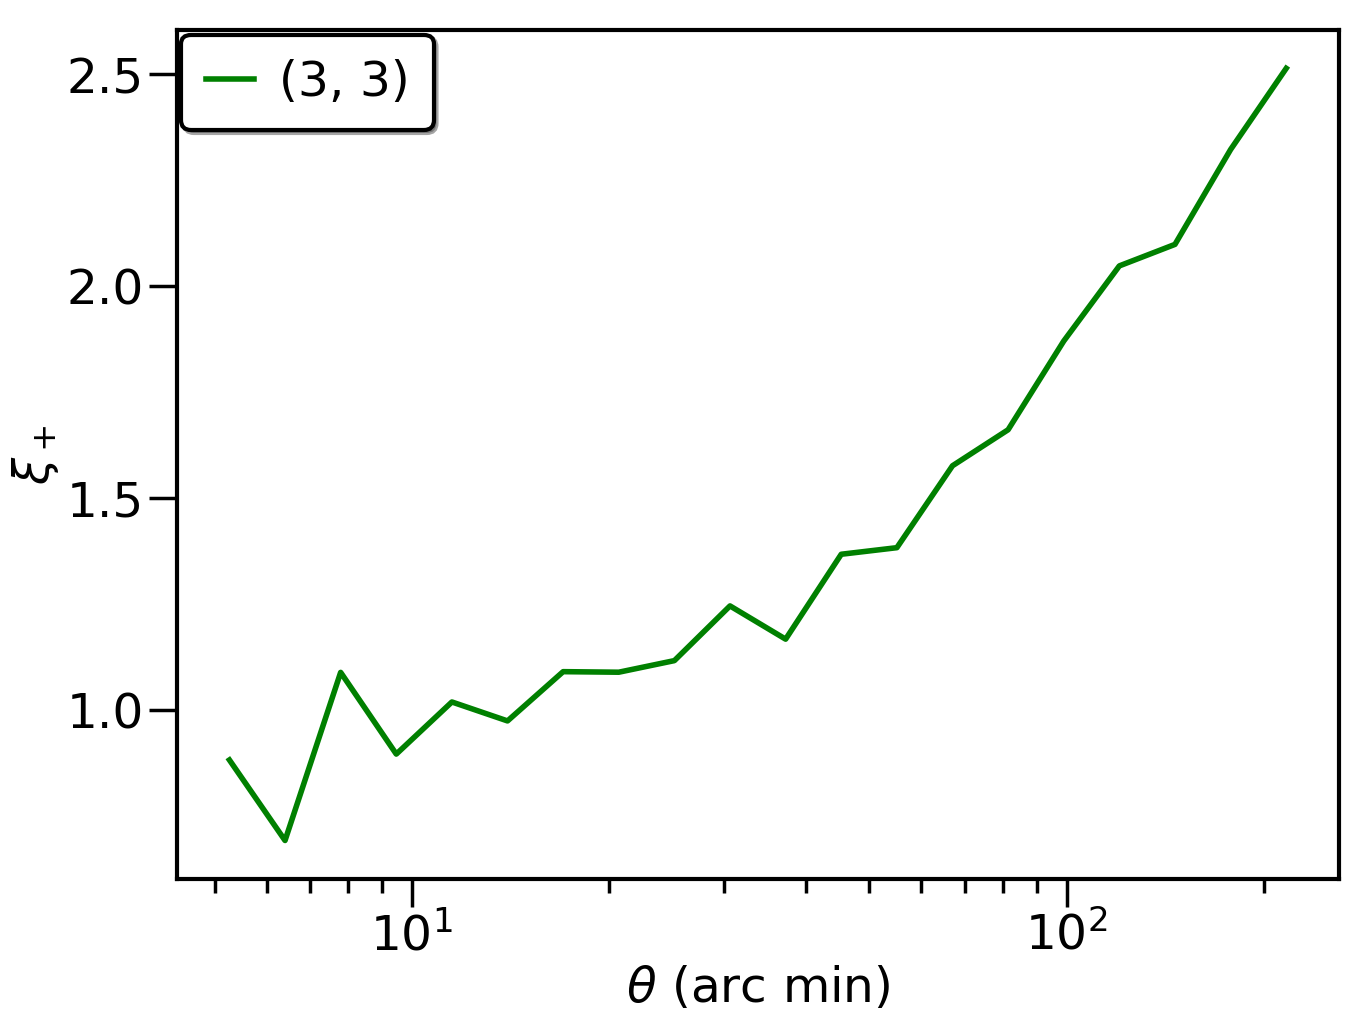

In [80]:
bm1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(cov_des[indx0:indx0+nth,indx0:indx0+nth])),
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [ ]:
crash

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)